In [196]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from time import time
import pandas as pd
import logging as logger

from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC

logger.basicConfig(filename='qsvm.log', encoding='utf-8', level=logger.DEBUG)

In [197]:
def SSDP_DDoS(training_size, test_size, n, PLOT_DATA=True):
    data = pd.read_csv('../NewDataset/output_file.csv', engine="python")
    logger.debug("Convert SSDP_DDoS data ... ")
    class_labels = [r'BENING', r'DrDoS_SSDP']

    data = data.replace("BENIGN", 0
    data = data.replace("DDoS", 1)
    data = data[np.isfinite(data).all(1)]
    logger.debug("Convert logger message with data ... ")
    
    data = data.iloc[4975:5025]
    data = data[[" Flow Duration", " Average Packet Size", "Active Mean"," Label"]]    
    y = np.array(data[' Label'])
    data = data.drop(columns=[' Label'])
    x = StandardScaler().fit_transform(np.array(data))
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=109)
   
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    logger.debug(str(X_train.shape) + " records are used for training")
    logger.debug(str(X_test.shape) + " records are used for training")

    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_test[Y_test == k, :])[:test_size] for k, key in enumerate(class_labels)}
    
    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]
            label = 'DDoS' if k == 1 else 'BENIGN'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("DDoS_SSDP Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()
        

    return X_train, Y_train, X_test, Y_test, test_input, class_labels

In [198]:
import operator

def split_dataset_to_data_and_labels(dataset, class_names=None):
    data = []
    labels = []
    if class_names is None:
        sorted_classes_name = sorted(list(dataset.keys()))
        class_to_label = {k: idx for idx, k in enumerate(sorted_classes_name)}
    else:
        class_to_label = class_names
    sorted_label = sorted(class_to_label.items(), key=operator.itemgetter(1))
    for class_name, _ in sorted_label:
        values = dataset[class_name]
        for value in values:
            data.append(value)
            try:
                labels.append(class_to_label[class_name])
            except Exception as ex:  # pylint: disable=broad-except
                raise KeyError('The dataset has different class names to '
                               'the training data. error message: {}'.format(ex)) from ex
    data = np.asarray(data)
    labels = np.asarray(labels)
    if class_names is None:
        return [data, labels], class_to_label
    else:
        return [data, labels]

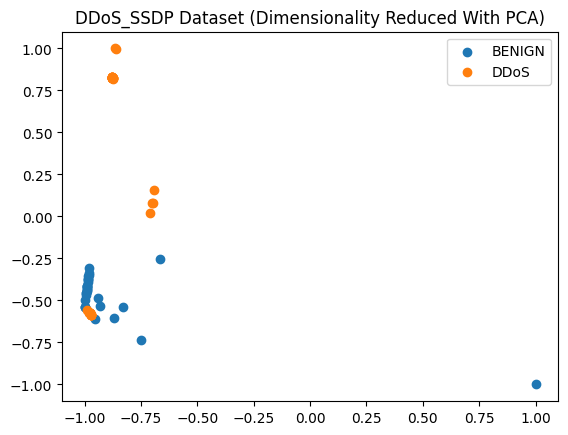

In [199]:
n = 3 # How many features to use (dimensionality)
training_dataset_size = int(100*0.8)
testing_dataset_size = int(100*0.2)

X_train, Y_train, X_test, Y_test, test_input, class_labels = SSDP_DDoS(training_dataset_size, testing_dataset_size, n)
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

In [200]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=3, reps=3, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate, verbose=True, cache_size=1000)
start = time()
adhoc_svc.fit(X_train, Y_train)
end = time()

adhoc_score_callable_function = adhoc_svc.score(X_test, Y_test)
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")
logger.debug("Accuracy = " + str(adhoc_score_callable_function) + "Training time = " +  str(end-start))

[LibSVM]*
optimization finished, #iter = 30
obj = -15.540702, rho = -0.310988
nSV = 28, nBSV = 19
Total nSV = 28
Callable kernel classification test score: 1.0


In [201]:
print (adhoc_score_callable_function)

1.0


In [202]:
adhoc_svc = SVC(kernel="poly", verbose=True, cache_size=1000)
start = time()
adhoc_svc.fit(X_train, Y_train)
end = time()
    
adhoc_score_callable_function = adhoc_svc.score(X_test, Y_test)
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")
logger.debug("Accuracy = " + str(adhoc_score_callable_function) + "Training time = " +  str(end-start))

[LibSVM]*
optimization finished, #iter = 29
obj = -29.317569, rho = 0.418701
nSV = 38, nBSV = 34
Callable kernel classification test score: 0.9
Total nSV = 38


In [203]:
print (adhoc_score_callable_function)

0.9


In [204]:
adhoc_svc = SVC(kernel="rbf", verbose=True, cache_size=1000)
start = time()
adhoc_svc.fit(X_train, Y_train)
end = time()

adhoc_score_callable_function = adhoc_svc.score(X_test, Y_test)
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")
logger.debug("Accuracy = " + str(adhoc_score_callable_function) + "Training time = " +  str(end-start))

[LibSVM]*
optimization finished, #iter = 29
obj = -34.152737, rho = -0.237618
nSV = 40, nBSV = 36
Total nSV = 40
Callable kernel classification test score: 0.7666666666666667


In [205]:
adhoc_svc = SVC(kernel="linear", verbose=True, cache_size=1000)
start = time()
adhoc_svc.fit(X_train, Y_train)
end = time()

adhoc_score_callable_function = adhoc_svc.score(X_test, Y_test)
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")
logger.debug("Accuracy = " + str(adhoc_score_callable_function) + "Training time = " +  str(end-start))

[LibSVM]*
optimization finished, #iter = 51
obj = -38.191601, rho = 0.291296
nSV = 41, nBSV = 38
Total nSV = 41
Callable kernel classification test score: 0.7333333333333333
